In [1]:
!python.exe -m pip install --upgrade pip
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install openpyxl
!pip install doubleml
! pip install linearmodels
! pip install pgmpy

/bin/bash: line 1: python.exe: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.3/443.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:0

In [2]:
# Подключим необходимые библиотеки
import numpy as np
import pandas as pd
import scipy as scipy
from copy import deepcopy
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
import seaborn as sns
from sklearn.model_selection import train_test_split
import networkx as nx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import doubleml as dml
from sklearn.ensemble import RandomForestClassifier       # случайный лес (классификация)
from sklearn.ensemble import RandomForestRegressor        # случайный лес (регрессия)
from sklearn.ensemble import GradientBoostingClassifier   # градиентный бустинг (классификация)
from sklearn.ensemble import GradientBoostingRegressor    # градиентный бустинг (регрессия)
from sklearn.linear_model import Lasso                    # Лассо
from sklearn.base import clone
import statsmodels.api as sm                              # линейная регрессия
from sklearn.linear_model import LogisticRegression       # логистическая регрессия
from linearmodels.iv import IV2SLS, compare


from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score, precision_score, make_scorer
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination


# 2. Генерация и предварительная обработка данных

# 2.1 - 2.2

**Зависимая переменная непрерывная** - кассовые сборы.

**Переменная воздействия бинарная** - факт наличия сцен 18+, то есть рейтинг R (1 - есть, 0 - нет).

**Инструментальная переменная** - переменная, отвечающая за жанры, в которых режиссер снимал в прошлом (1 - ранее снимал фильмы с возрастным рейтингом R, 0 иначе).

**Контрольные переменные**:

*   сиквел (бинарная, 1 -- если фильм является продолжением серии фильмов, 0 иначе).
*   оценки пользователей (непрерывная).
*   бюджет (непрерывная, в млн долларов)









In [3]:
# Для воспроизводимости
np.random.seed(123)

# Число наблюдений
n = 10000

# 2.3

--- Контрольные переменные ---

In [4]:
# Сиквел (бинарная переменная)
sequel = np.random.binomial(1, 0.3, size=n)

# Оценки пользователей (непрерывная переменная от 0 до 10)
ratings = np.clip(norm.rvs(loc=6.5, scale=1.0, size=n), 0, 10)

# Бюджет фильма (в млн долларов)
budget = np.clip(norm.rvs(loc=88, scale=10, size=n), 5, 450)

--- Инструментальная переменная: жанры, в которых режиссер снимал раньше ---

In [5]:
genre_index = (
    0.3 * ratings +                     # разумный вклад рейтинга
    1.5 * sequel                       # умеренное влияние сиквела
     - 4                             # СДВИГ уменьшен для балансировки вероятностей
)

# Немного шума, чтобы значения не слипались
genre_index += np.random.normal(0, 1.0, size=n)

# Вероятность
genre_prob = logistic.cdf(genre_index/2)

# Бинарная переменная
director_past_genre = np.random.binomial(1, genre_prob)

# Проверим долю единиц
print("Доля единиц в director_past_genre:", director_past_genre.mean())

Доля единиц в director_past_genre: 0.3299


 --- Переменная воздействия: рейтинг R ---

In [6]:
# Эндогенная переменная - может зависеть от жанров, бюджета, оценок
rating_index = 2.2 * director_past_genre + 0.01 * budget  + 0.1 * ratings + 0.001*budget**2 + 0.07*np.log(ratings+1) - 8 + 0.002 *director_past_genre*ratings
rating_prob = logistic.cdf(rating_index)
rating_r = (uniform.rvs(size=n) < rating_prob).astype(int)

In [7]:
# Проверка доли единиц
print("Доля фильмов с рейтингом R:", np.mean(rating_r))

Доля фильмов с рейтингом R: 0.7856


 --- Зависимая переменная: кассовые сборы ---

In [8]:
# Ошибки
error0 = t.rvs(df=10, size=n) * 8
error1 = (expon.rvs(size=n, scale=25) - 10) + 0.001 * budget

# Моделируем сборы в зависимости от наличия рейтинга R
# С рейтингом R
g1 = -2* np.log(ratings + 1) + 1.0 * budget + 12 * sequel - 0.03 * budget *  + 0.3 * director_past_genre

# 0 — нет рейтинга R
g0 = -1.5 * np.log(ratings + 1) + 1.3 * budget + 10 * sequel + 0.017 * ratings**2 + 0.6 *director_past_genre


In [9]:
# Сборы
revenue = rating_r * (g1 + error1) + (1 - rating_r) * (g0 + error0) + 140

Датафрейм

In [10]:
df = pd.DataFrame({
    'revenue': revenue,
    'rating_r': rating_r,
    'sequel': sequel,
    'ratings': ratings,
    'budget': budget,
    'director_past_genre': director_past_genre
})

# --- Корреляционная матрица ---
print("\nКорреляционная матрица:")
print(df.corr(numeric_only=True).round(2))



Корреляционная матрица:
                     revenue  rating_r  sequel  ratings  budget  \
revenue                 1.00      0.02    0.21    -0.02    0.34   
rating_r                0.02      1.00    0.04     0.04    0.46   
sequel                  0.21      0.04    1.00     0.00    0.00   
ratings                -0.02      0.04    0.00     1.00   -0.02   
budget                  0.34      0.46    0.00    -0.02    1.00   
director_past_genre    -0.02      0.24    0.16     0.06   -0.01   

                     director_past_genre  
revenue                            -0.02  
rating_r                            0.24  
sequel                              0.16  
ratings                             0.06  
budget                             -0.01  
director_past_genre                 1.00  


In [11]:
df.corr(numeric_only=True).round(2)

,revenue,rating_r,sequel,ratings,budget,director_past_genre
revenue,1.00,0.02,0.21,-0.02,0.34,-0.02
rating_r,0.02,1.00,0.04,0.04,0.46,0.24
sequel,0.21,0.04,1.00,0.00,0.00,0.16
ratings,-0.02,0.04,0.00,1.00,-0.02,0.06
budget,0.34,0.46,0.00,-0.02,1.00,-0.01
director_past_genre,-0.02,0.24,0.16,0.06,-0.01,1.00


In [12]:
df[['revenue', 'budget', 'ratings']].mean()

,0
revenue,244.322412
budget,87.839707
ratings,6.518583


Проверка мулльтиколлинеарности

In [13]:
X = sm.add_constant(df[['budget', 'rating_r', 'revenue']])
vif_data = pd.DataFrame()
vif_data['переменная'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,переменная,VIF
0,const,133.040437
1,budget,1.461462
2,rating_r,1.295979
3,revenue,1.156855


VIF для переменных оказался ниже 10, что говорит об отсутствии мультиколлинеарности

Описательные статистики

In [14]:
df[['revenue', 'ratings', 'budget']].describe().loc[['mean', 'std', '50%', 'min', 'max']]

,revenue,ratings,budget
mean,244.322412,6.518583,87.839707
std,24.927627,1.007164,9.953730
50%,240.148695,6.517282,87.785386
min,187.819689,2.980575,51.251973
max,451.915922,10.000000,128.646299



Описательные статистики для непрерывных переменных:
         revenue    ratings      budget
mean  244.322412   6.518583   87.839707
std    24.927627   1.007164    9.953730
50%   240.148695   6.517282   87.785386
min   187.819689   2.980575   51.251973
max   451.915922  10.000000  128.646299

Описательные статистики для бинарных переменных:
rating_r: доля = 0.786, количество = 7856
director_past_genre: доля = 0.330, количество = 3299
sequel: доля = 0.300, количество = 3005


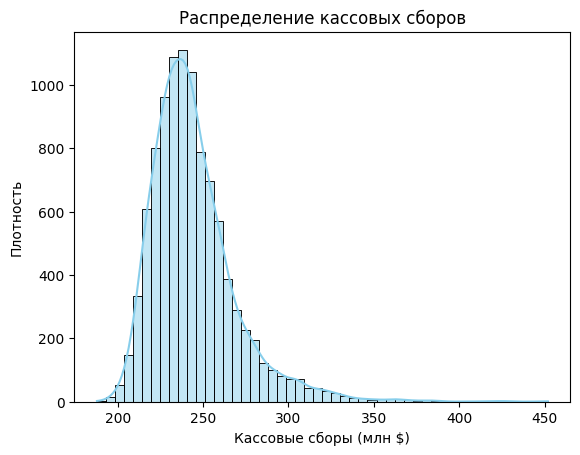

In [15]:
print("\nОписательные статистики для непрерывных переменных:")
print(df[['revenue', 'ratings', 'budget']].describe().loc[['mean', 'std', '50%', 'min', 'max']])

print("\nОписательные статистики для бинарных переменных:")
for var in ['rating_r', 'director_past_genre', 'sequel']:
    count = df[var].sum()
    share = count / n
    print(f"{var}: доля = {share:.3f}, количество = {count}")

# Визуализация распределения сборов
sns.histplot(df['revenue'], bins=50, kde=True, color='skyblue')
plt.title('Распределение кассовых сборов')
plt.xlabel('Кассовые сборы (млн $)')
plt.ylabel('Плотность')
plt.show()

Доля единиц выполняется для всех бинарных переменных, а число наблюдений больше 1000

# 2.4

In [16]:
# Разделение на обучающую и тестовую выборку (25% в тест)
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Проверка размеров
print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер обучающей выборки: (7500, 6)
Размер тестовой выборки: (2500, 6)


# 2.5

Проверка валидности и релевантности инструмента

Релевантность через F-статистику первого шага 2МНК

In [17]:
# Релевантность инструмента
# Первый шаг: rating_r - зависимая переменная, а инструмент - director_past_genre
first_stage = smf.ols('rating_r ~ director_past_genre + budget + ratings + sequel', data=df).fit()
first_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rating_r   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     932.2
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        10:23:26   Log-Likelihood:                -3698.0
No. Observations:               10000   AIC:                             7406.
Df Residuals:                    9995   BIC:                             7442.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.0324      0.039    -26.560      0.000      -1.109      -0.956
director_past_genre     0.2160      0.008     28.576      0.000       0.201       0.231
budget                  0.0190      0.000     53.945      0.000       0.018       0.020
ratings                 0.0121      0.003      3.485      0.000       0.005       0.019
sequel                 -0.0020      0.008     -0.261      0.794      -0.017       0.013
==============================================================================
Omnibus:                      875.183   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1079.380
Skew:                          -0.790   Prob(JB):                    4.13e-235
Kurtosis:                       2.692   Cond. No.                         985.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# F-статистика на значимость инструмента:
f_stat = first_stage.f_test("director_past_genre = 0")
print("\nF-статистика на значимость инструмента:")
print(f_stat)


F-статистика на значимость инструмента:
<F test: F=816.5928084614435, p=1.031111470800344e-172, df_denom=1e+04, df_num=1>


Результат: F-статистика больше 10, p-value околонулевое, что говорит о релевантности инструмента.

Валидность

IV-регрессия: зависимая переменная — revenue, эндогенная — rating_r, инструмент — director_past_genre

In [19]:

# IV модель
iv_model = IV2SLS.from_formula(
    'revenue ~ 1 + budget + ratings + sequel + [rating_r ~ director_past_genre]',
    data=df
).fit()

# OLS (просто регрессия без инструмента)
ols_model = IV2SLS.from_formula(
    'revenue ~ 1 + budget + ratings + sequel + rating_r',
    data=df
).fit()

# Сравнение моделей
comparison = compare({'OLS': ols_model, 'IV': iv_model})
comparison

,OLS,IV
Dep. Variable,revenue,revenue
Estimator,OLS,IV-2SLS
No. Observations,10000,10000
Cov. Est.,robust,robust
R-squared,0.1835,0.1824
Adj. R-squared,0.1832,0.1821
F-statistic,2273.5,2198.9
P-value (F-stat),0.0000,0.0000
==================,===========,===========
Intercept,158.33,156.08


Результаты: Инструмент director_past_genre — валидный (не коррелирует с ошибками) и релевантный (значимо влияет на rating_r)

# 3. Классификация

## 3.1. Выбор признаков для классификации

Целевая переменная:

rating_r — факт наличия сцен 18+ (1 — есть, 0 — нет)

Используемые признаки:

- sequel — сиквел (контрольная переменная)
- ratings — пользовательские оценки (контрольная переменная)
- budget — бюджет (контрольная переменная)

Обоснование выбора каждого признака:

- sequel - сиквелы часто наследуют рейтинг предыдущих фильмов серии.
- ratings - оценки пользователей могут отражать особенности аудитории и косвенно — наличие сцен 18+.
- budget - бюджет может влиять на жанр и целевую аудиторию фильма, а значит и на вероятность наличия сцен 18+.


## 3.2. Выбор моделей, обоснование и реализация

- Логистическая регрессия - классическая интерпретируемая модель для бинарной классификации. Хорошо работает при линейных зависимостях между признаками и целевой переменной. Позволяет оценить вклад каждого признака.
- Случайный лес (Random Forest) - мощный ансамблевый метод, устойчив к выбросам и мультиколлинеарности, хорошо работает с разными типами признаков, автоматически оценивает важность признаков.
- Метод k-ближайших соседей (KNN) - простой и интуитивный метод, не делает предположений о распределении данных, хорошо работает при небольшом числе признаков и несложных границах классов.


In [20]:
# Признаки и целевая переменная
features = ['sequel', 'ratings', 'budget']
target = 'rating_r'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Масштабирование для KNN и логистической регрессии
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Логистическая регрессия
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Случайный лес
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [22]:
results = []

# Логистическая регрессия
train_acc_logreg = accuracy_score(y_train, logreg.predict(X_train_scaled))
test_acc_logreg = accuracy_score(y_test, logreg.predict(X_test_scaled))
cv_acc_logreg = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
results.append(['Logistic Regression', train_acc_logreg, test_acc_logreg, cv_acc_logreg])

# Случайный лес
train_acc_rf = accuracy_score(y_train, rf.predict(X_train))
test_acc_rf = accuracy_score(y_test, rf.predict(X_test))
cv_acc_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
results.append(['Random Forest', train_acc_rf, test_acc_rf, cv_acc_rf])

# KNN
train_acc_knn = accuracy_score(y_train, knn.predict(X_train_scaled))
test_acc_knn = accuracy_score(y_test, knn.predict(X_test_scaled))
cv_acc_knn = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
results.append(['KNN', train_acc_knn, test_acc_knn, cv_acc_knn])

# Таблица результатов
results_df = pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Test Accuracy', 'CV Accuracy'])
print(results_df)

                 Model  Train Accuracy  Test Accuracy  CV Accuracy
0  Logistic Regression        0.820000         0.8108     0.819467
1        Random Forest        0.827867         0.8080     0.818800
2                  KNN        0.854933         0.7808     0.798800


## 3.3. Тюнинг гиперпараметров и сравнение моделей

Необходимо для каждой из трёх моделей подобрать оптимальные гиперпараметры с помощью кросс-валидации (GridSearchCV).


In [23]:
# 1. Логистическая регрессия
logreg_params = {'C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                           logreg_params, cv=5, scoring='accuracy')
logreg_grid.fit(X_train_scaled, y_train)

# 2. Случайный лес
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, None]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                      rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# 3. KNN
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy')

In [24]:
# Функция для сбора результатов
def get_results(model, grid, Xtr, Xte, ytr, yte):
    # До тюнинга
    base_model = model
    base_model.fit(Xtr, ytr)
    base_train_acc = accuracy_score(ytr, base_model.predict(Xtr))
    base_test_acc = accuracy_score(yte, base_model.predict(Xte))
    base_cv_acc = cross_val_score(base_model, Xtr, ytr, cv=5, scoring='accuracy').mean()
    # После тюнинга
    best_model = grid.best_estimator_
    best_train_acc = accuracy_score(ytr, best_model.predict(Xtr))
    best_test_acc = accuracy_score(yte, best_model.predict(Xte))
    best_cv_acc = grid.best_score_
    return [str(base_model), grid.param_grid, base_cv_acc, base_test_acc,
            grid.best_params_, best_cv_acc, best_test_acc]

results = []
results.append(get_results(LogisticRegression(max_iter=1000, random_state=42), logreg_grid, X_train_scaled, X_test_scaled, y_train, y_test))
results.append(get_results(RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42), rf_grid, X_train, X_test, y_train, y_test))
results.append(get_results(KNeighborsClassifier(n_neighbors=5), knn_grid, X_train_scaled, X_test_scaled, y_train, y_test))

results_df = pd.DataFrame(results, columns=[
    'Model (base)', 'Params grid', 'CV acc (base)', 'Test acc (base)',
    'Best params', 'CV acc (best)', 'Test acc (best)'
])
print(results_df)

                                        Model (base)  \
0  LogisticRegression(max_iter=1000, random_state...   
1  RandomForestClassifier(max_depth=5, random_sta...   
2                             KNeighborsClassifier()   

                                         Params grid  CV acc (base)  \
0                     {'C': [0.01, 0.1, 1, 10, 100]}       0.819467   
1  {'n_estimators': [50, 100, 200], 'max_depth': ...       0.818800   
2                      {'n_neighbors': [3, 5, 7, 9]}       0.798800   

   Test acc (base)                            Best params  CV acc (best)  \
0           0.8108                            {'C': 0.01}       0.819600   
1           0.8080  {'max_depth': 5, 'n_estimators': 100}       0.818800   
2           0.7808                     {'n_neighbors': 9}       0.805733   

   Test acc (best)  
0           0.8104  
1           0.8080  
2           0.7912  


## 3.3. OOB (out-of-bag) ошибка.



In [25]:

# Сетка гиперпараметров
n_estimators_list = [50, 100, 200]
max_depth_list = [3, 5, 7, None]

best_oob_score = 0
best_params_oob = None
results_oob = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        rf_oob = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        rf_oob.fit(X_train, y_train)
        oob_score = rf_oob.oob_score_
        test_acc = accuracy_score(y_test, rf_oob.predict(X_test))
        results_oob.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'OOB score': oob_score,
            'Test accuracy': test_acc
        })
        if oob_score > best_oob_score:
            best_oob_score = oob_score
            best_params_oob = (n_estimators, max_depth)

# Таблица результатов
results_oob_df = pd.DataFrame(results_oob)
print(results_oob_df)
print(f"\nЛучшие параметры по OOB: n_estimators={best_params_oob[0]}, max_depth={best_params_oob[1]}, OOB score={best_oob_score:.4f}")

    n_estimators  max_depth  OOB score  Test accuracy
0             50        3.0   0.809333         0.8016
1             50        5.0   0.816267         0.8108
2             50        7.0   0.817067         0.8012
3             50        NaN   0.795333         0.7820
4            100        3.0   0.807867         0.8004
5            100        5.0   0.818267         0.8080
6            100        7.0   0.816933         0.8024
7            100        NaN   0.796800         0.7784
8            200        3.0   0.811200         0.8004
9            200        5.0   0.818667         0.8064
10           200        7.0   0.818133         0.8020
11           200        NaN   0.801467         0.7772

Лучшие параметры по OOB: n_estimators=200, max_depth=5, OOB score=0.8187


## 3.4. Альтернативный критерий качества

F1-score — хороший выбор, если классы несбалансированы (у нас доля фильмов с рейтингом R ≈ 0.77).

In [26]:

f1_scorer = make_scorer(f1_score)

# Логистическая регрессия
logreg_grid_f1 = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': [0.01, 0.1, 1, 10, 100]},
    cv=5, scoring=f1_scorer
)
logreg_grid_f1.fit(X_train_scaled, y_train)

# Случайный лес
rf_grid_f1 = GridSearchCV(
    RandomForestClassifier(random_state=42),
    {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, None]},
    cv=5, scoring=f1_scorer
)
rf_grid_f1.fit(X_train, y_train)

# KNN
knn_grid_f1 = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': [3, 5, 7, 9]},
    cv=5, scoring=f1_scorer
)
knn_grid_f1.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [27]:
# Логистическая регрессия
logreg_best_f1 = logreg_grid_f1.best_estimator_
f1_train_logreg = f1_score(y_train, logreg_best_f1.predict(X_train_scaled))
f1_test_logreg = f1_score(y_test, logreg_best_f1.predict(X_test_scaled))
f1_cv_logreg = logreg_grid_f1.best_score_

# Случайный лес
rf_best_f1 = rf_grid_f1.best_estimator_
f1_train_rf = f1_score(y_train, rf_best_f1.predict(X_train))
f1_test_rf = f1_score(y_test, rf_best_f1.predict(X_test))
f1_cv_rf = rf_grid_f1.best_score_

# KNN
knn_best_f1 = knn_grid_f1.best_estimator_
f1_train_knn = f1_score(y_train, knn_best_f1.predict(X_train_scaled))
f1_test_knn = f1_score(y_test, knn_best_f1.predict(X_test_scaled))
f1_cv_knn = knn_grid_f1.best_score_

# Таблица результатов
f1_results = pd.DataFrame([
    ['Logistic Regression', logreg_grid_f1.best_params_, f1_cv_logreg, f1_train_logreg, f1_test_logreg],
    ['Random Forest', rf_grid_f1.best_params_, f1_cv_rf, f1_train_rf, f1_test_rf],
    ['KNN', knn_grid_f1.best_params_, f1_cv_knn, f1_train_knn, f1_test_knn]
], columns=['Model', 'Best params (F1)', 'CV F1', 'Train F1', 'Test F1'])

print(f1_results)

                 Model                      Best params (F1)     CV F1  \
0  Logistic Regression                           {'C': 0.01}  0.893885   
1        Random Forest  {'max_depth': 5, 'n_estimators': 50}  0.892523   
2                  KNN                    {'n_neighbors': 9}  0.882638   

   Train F1   Test F1  
0  0.893245  0.888049  
1  0.897767  0.888153  
2  0.901354  0.872993  


## 3.4 Собственный критерий
Пример собственного критерия:
- "Взвешенная F1-метрика с приоритетом на полноту (Recall)"

Допустим, для задачи важнее не пропустить фильмы с рейтингом R (важна полнота), но при этом не хочется сильно терять в точности.

Custom Score = 0.7 $\cdot$ Recall + 0.3 $\cdot$ Precision


In [28]:
def custom_score_func(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return 0.7 * recall + 0.3 * precision

custom_scorer = make_scorer(custom_score_func)

In [29]:
# Логистическая регрессия
logreg_grid_custom = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': [0.01, 0.1, 1, 10, 100]},
    cv=5, scoring=custom_scorer
)
logreg_grid_custom.fit(X_train_scaled, y_train)

# Случайный лес
rf_grid_custom = GridSearchCV(
    RandomForestClassifier(random_state=42),
    {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, None]},
    cv=5, scoring=custom_scorer
)
rf_grid_custom.fit(X_train, y_train)

# KNN
knn_grid_custom = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': [3, 5, 7, 9]},
    cv=5, scoring=custom_scorer
)
knn_grid_custom.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_score_func, response_method='predict'))

In [30]:
# Логистическая регрессия
logreg_best_custom = logreg_grid_custom.best_estimator_
custom_train_logreg = custom_score_func(y_train, logreg_best_custom.predict(X_train_scaled))
custom_test_logreg = custom_score_func(y_test, logreg_best_custom.predict(X_test_scaled))
custom_cv_logreg = logreg_grid_custom.best_score_

# Случайный лес
rf_best_custom = rf_grid_custom.best_estimator_
custom_train_rf = custom_score_func(y_train, rf_best_custom.predict(X_train))
custom_test_rf = custom_score_func(y_test, rf_best_custom.predict(X_test))
custom_cv_rf = rf_grid_custom.best_score_

# KNN
knn_best_custom = knn_grid_custom.best_estimator_
custom_train_knn = custom_score_func(y_train, knn_best_custom.predict(X_train_scaled))
custom_test_knn = custom_score_func(y_test, knn_best_custom.predict(X_test_scaled))
custom_cv_knn = knn_grid_custom.best_score_

# Таблица результатов
custom_results = pd.DataFrame([
    ['Logistic Regression', logreg_grid_custom.best_params_, custom_cv_logreg, custom_train_logreg, custom_test_logreg],
    ['Random Forest', rf_grid_custom.best_params_, custom_cv_rf, custom_train_rf, custom_test_rf],
    ['KNN', knn_grid_custom.best_params_, custom_cv_knn, custom_train_knn, custom_test_knn]
], columns=['Model', 'Best params (Custom)', 'CV Custom', 'Train Custom', 'Test Custom'])

print(custom_results)

                 Model                   Best params (Custom)  CV Custom  \
0  Logistic Regression                            {'C': 0.01}   0.924855   
1        Random Forest  {'max_depth': 3, 'n_estimators': 200}   0.931897   
2                  KNN                     {'n_neighbors': 9}   0.901665   

   Train Custom  Test Custom  
0      0.922426     0.923002  
1      0.933327     0.929901  
2      0.920434     0.894247  


## 3.5. Построение ROC-кривых и сравнение по AUC


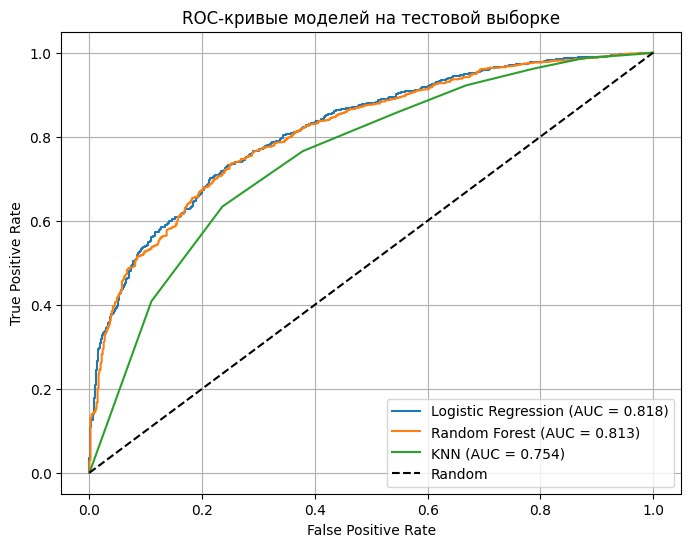

                 Model       AUC
0  Logistic Regression  0.818001
1        Random Forest  0.813350
2                  KNN  0.754390


In [31]:

plt.figure(figsize=(8, 6))

# Логистическая регрессия
y_score_logreg = logreg_best_f1.predict_proba(X_test_scaled)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
auc_logreg = roc_auc_score(y_test, y_score_logreg)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.3f})')

# Случайный лес
y_score_rf = rf_best_f1.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
auc_rf = roc_auc_score(y_test, y_score_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

# KNN
y_score_knn = knn_best_f1.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
auc_knn = roc_auc_score(y_test, y_score_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')

# Диагональ случайного классификатора
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей на тестовой выборке')
plt.legend()
plt.grid()
plt.show()

# Таблица AUC
auc_table = pd.DataFrame([
    ['Logistic Regression', auc_logreg],
    ['Random Forest', auc_rf],
    ['KNN', auc_knn]
], columns=['Model', 'AUC'])

print(auc_table)

## 3.5. Байесовская сеть

Построить ROC-кривую и вычислить AUC для Байесовской сети на тестовой выборке.


Описание простейшей структуры сети (DAG):

- sequel → rating_r
- ratings → rating_r
- budget → rating_r


In [32]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Определим структуру сети (DAG)
model = DiscreteBayesianNetwork([
    ('sequel', 'rating_r'),
    ('ratings', 'rating_r'),
    ('budget', 'rating_r')
])

# Дискретизация непрерывных признаков для pgmpy (например, 4 бина)
from sklearn.preprocessing import KBinsDiscretizer

disc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
train_disc = train_df.copy()
test_disc = test_df.copy()
for col in ['ratings', 'budget']:
    train_disc[col] = disc.fit_transform(train_df[[col]])
    test_disc[col] = disc.transform(test_df[[col]])

# Обучение параметров сети
model.fit(train_disc, estimator=BayesianEstimator, prior_type='BDeu')

# Инференс
infer = VariableElimination(model)

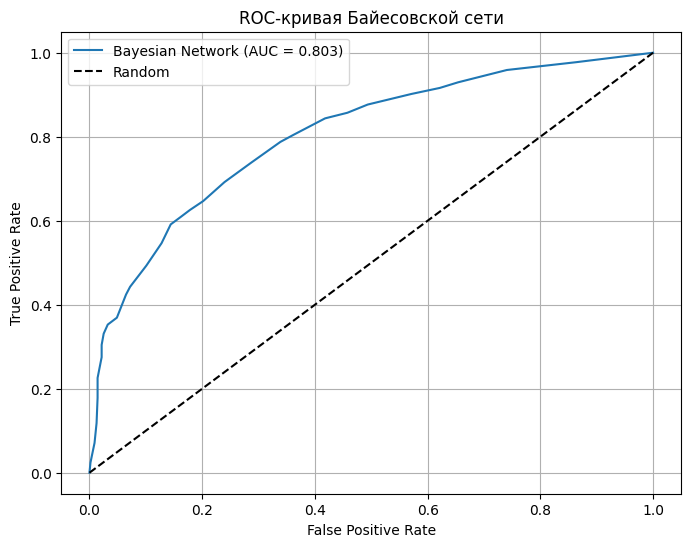

AUC Байесовской сети: 0.803


In [33]:
# Получим вероятности для тестовой выборки
y_proba_bn = []
for _, row in test_disc.iterrows():
    q = infer.query(variables=['rating_r'], evidence={
        'sequel': int(row['sequel']),
        'ratings': int(row['ratings']),
        'budget': int(row['budget'])
    }, show_progress=False)
    y_proba_bn.append(q.values[1])  # вероятность rating_r=1

# ROC-кривая и AUC
from sklearn.metrics import roc_curve, roc_auc_score

fpr_bn, tpr_bn, _ = roc_curve(test_disc['rating_r'], y_proba_bn)
auc_bn = roc_auc_score(test_disc['rating_r'], y_proba_bn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bn, tpr_bn, label=f'Bayesian Network (AUC = {auc_bn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая Байесовской сети')
plt.legend()
plt.grid()
plt.show()

print(f"AUC Байесовской сети: {auc_bn:.3f}")

## 3.6. Матрица ошибок, оптимальный порог и прибыль


In [34]:
from sklearn.metrics import confusion_matrix

# Пример для логистической регрессии (порог 0.5)
y_pred_logreg = (logreg_best_f1.predict_proba(X_test_scaled)[:, 1] >= 0.5).astype(int)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion matrix (Logistic Regression):\n", cm_logreg)

Confusion matrix (Logistic Regression):
 [[ 146  409]
 [  65 1880]]


Пример цен ошибок:
- True Positive (TP): +100 (правильно найден фильм с рейтингом R)
- True Negative (TN): +10 (правильно найден фильм без рейтинга R)
- False Positive (FP): -20 (ошибочно помечен фильм как R)
- False Negative (FN): -50 (пропущен фильм с рейтингом R)

In [35]:

def profit_curve(y_true, y_proba, thresholds, tp=100, tn=10, fp=-20, fn=-50):
    profits = []
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred).ravel()
        profit = tp_ * tp + tn_ * tn + fp_ * fp + fn_ * fn
        profits.append(profit)
    return profits

# Для логистической регрессии
probas_train = logreg_best_f1.predict_proba(X_train_scaled)[:, 1]
thresholds = np.linspace(0, 1, 101)
profits = profit_curve(y_train, probas_train, thresholds)
best_thresh = thresholds[np.argmax(profits)]
print(f"Оптимальный порог для прибыли (LogReg): {best_thresh:.2f}")

Оптимальный порог для прибыли (LogReg): 0.14


In [36]:
# На тестовой выборке
probas_test = logreg_best_f1.predict_proba(X_test_scaled)[:, 1]
profit_test = profit_curve(y_test, probas_test, [best_thresh])[0]
auc_test = roc_auc_score(y_test, probas_test)
print(f"Прибыль на тесте (LogReg): {profit_test}, AUC: {auc_test:.3f}")

Прибыль на тесте (LogReg): 183310, AUC: 0.818


In [37]:

def profit_curve(y_true, y_proba, thresholds, tp=100, tn=10, fp=-20, fn=-50):
    profits = []
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred).ravel()
        profit = tp_ * tp + tn_ * tn + fp_ * fp + fn_ * fn
        profits.append(profit)
    return profits

In [38]:
# Предсказания вероятностей
probas_train_rf = rf_best_f1.predict_proba(X_train)[:, 1]
probas_test_rf = rf_best_f1.predict_proba(X_test)[:, 1]

# Поиск оптимального порога на обучающей выборке
thresholds = np.linspace(0, 1, 101)
profits_rf = profit_curve(y_train, probas_train_rf, thresholds)
best_thresh_rf = thresholds[np.argmax(profits_rf)]
print(f"Оптимальный порог для прибыли (Random Forest): {best_thresh_rf:.2f}")

# Прибыль и матрица ошибок на тесте
profit_test_rf = profit_curve(y_test, probas_test_rf, [best_thresh_rf])[0]
y_pred_rf = (probas_test_rf >= best_thresh_rf).astype(int)
cm_rf = confusion_matrix(y_test, y_pred_rf)
auc_test_rf = roc_auc_score(y_test, probas_test_rf)
print("Confusion matrix (Random Forest):\n", cm_rf)
print(f"Прибыль на тесте (Random Forest): {profit_test_rf}, AUC: {auc_test_rf:.3f}")

Оптимальный порог для прибыли (Random Forest): 0.34
Confusion matrix (Random Forest):
 [[  34  521]
 [   9 1936]]
Прибыль на тесте (Random Forest): 183070, AUC: 0.813


In [39]:
# Предсказания вероятностей
probas_train_knn = knn_best_f1.predict_proba(X_train_scaled)[:, 1]
probas_test_knn = knn_best_f1.predict_proba(X_test_scaled)[:, 1]

# Поиск оптимального порога на обучающей выборке
profits_knn = profit_curve(y_train, probas_train_knn, thresholds)
best_thresh_knn = thresholds[np.argmax(profits_knn)]
print(f"Оптимальный порог для прибыли (KNN): {best_thresh_knn:.2f}")

# Прибыль и матрица ошибок на тесте
profit_test_knn = profit_curve(y_test, probas_test_knn, [best_thresh_knn])[0]
y_pred_knn = (probas_test_knn >= best_thresh_knn).astype(int)
cm_knn = confusion_matrix(y_test, y_pred_knn)
auc_test_knn = roc_auc_score(y_test, probas_test_knn)
print("Confusion matrix (KNN):\n", cm_knn)
print(f"Прибыль на тесте (KNN): {profit_test_knn}, AUC: {auc_test_knn:.3f}")

Оптимальный порог для прибыли (KNN): 0.12
Confusion matrix (KNN):
 [[  25  530]
 [  10 1935]]
Прибыль на тесте (KNN): 182650, AUC: 0.754


## 3.6. Пример собственной функции прибыли

Пусть прибыль за каждый True Positive (TP) уменьшается, если их слишком много подряд.
Или, например, штраф за False Positive увеличивается с каждым новым FP.

Пример функции:
- За каждый TP: +100, но если TP > 1800, то за каждый следующий TP: +50.
- За каждый FP: -20, но если FP > 500, то за каждый следующий FP: -100.
- TN и FN — как раньше.

In [40]:
def custom_profit(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Базовые значения
    profit = 0
    # True Positive
    if tp <= 1800:
        profit += tp * 100
    else:
        profit += 1800 * 100 + (tp - 1800) * 50
    # False Positive
    if fp <= 500:
        profit += fp * -20
    else:
        profit += 500 * -20 + (fp - 500) * -100
    # True Negative
    profit += tn * 10
    # False Negative
    profit += fn * -50
    return profit

Поиск оптимального порога для модели

In [41]:
def custom_profit_curve(y_true, y_proba, thresholds):
    profits = []
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        profit = custom_profit(y_true, y_pred)
        profits.append(profit)
    return profits

# Для логистической регрессии
probas_train = logreg_best_f1.predict_proba(X_train_scaled)[:, 1]
thresholds = np.linspace(0, 1, 101)
profits_custom = custom_profit_curve(y_train, probas_train, thresholds)
best_thresh_custom = thresholds[np.argmax(profits_custom)]
print(f"Оптимальный порог для custom прибыли (LogReg): {best_thresh_custom:.2f}")

Оптимальный порог для custom прибыли (LogReg): 0.59


In [42]:
probas_test = logreg_best_f1.predict_proba(X_test_scaled)[:, 1]
profit_test_custom = custom_profit(y_test, (probas_test >= best_thresh_custom).astype(int))
print(f"Custom прибыль на тесте (LogReg): {profit_test_custom}")

Custom прибыль на тесте (LogReg): 169010


In [43]:
# Random Forest
probas_train_rf = rf_best_f1.predict_proba(X_train)[:, 1]
profits_rf_custom = custom_profit_curve(y_train, probas_train_rf, thresholds)
best_thresh_rf_custom = thresholds[np.argmax(profits_rf_custom)]
print(f"Оптимальный порог для custom прибыли (Random forest): {best_thresh_rf_custom:.2f}")
probas_test_rf = rf_best_f1.predict_proba(X_test)[:, 1]
profit_test_rf_custom = custom_profit(y_test, (probas_test_rf >= best_thresh_rf_custom).astype(int))
print(f"Custom прибыль на тесте (Random Forest): {profit_test_rf_custom}")

# KNN
probas_train_knn = knn_best_f1.predict_proba(X_train_scaled)[:, 1]
profits_knn_custom = custom_profit_curve(y_train, probas_train_knn, thresholds)
best_thresh_knn_custom = thresholds[np.argmax(profits_knn_custom)]
print(f"Оптимальный порог для custom прибыли (KNN): {best_thresh_knn_custom:.2f}")
probas_test_knn = knn_best_f1.predict_proba(X_test_scaled)[:, 1]
profit_test_knn_custom = custom_profit(y_test, (probas_test_knn >= best_thresh_knn_custom).astype(int))
print(f"Custom прибыль на тесте (KNN): {profit_test_knn_custom}")

Оптимальный порог для custom прибыли (Random forest): 0.56
Custom прибыль на тесте (Random Forest): 169150
Оптимальный порог для custom прибыли (KNN): 0.45
Custom прибыль на тесте (KNN): 166270



## 3.7. Байесовская сеть: предполагаемый DAG, обучение структуры и сравнение

Обучение структуры Байесовской сети: Вместо того чтобы задавать структуру вручную, можно использовать алгоритмы обучения структуры из данных. Библиотека pgmpy поддерживает несколько таких алгоритмов (например, HillClimbSearch).


AUC для предполагаемого DAG (ручная структура): 0.8029


  0%|          | 0/1000000 [00:00<?, ?it/s]


Структура, обученная алгоритмом HillClimbSearch:
[('budget', 'rating_r'), ('rating_r', 'sequel')]
AUC для DAG с обученной структурой: 0.7971


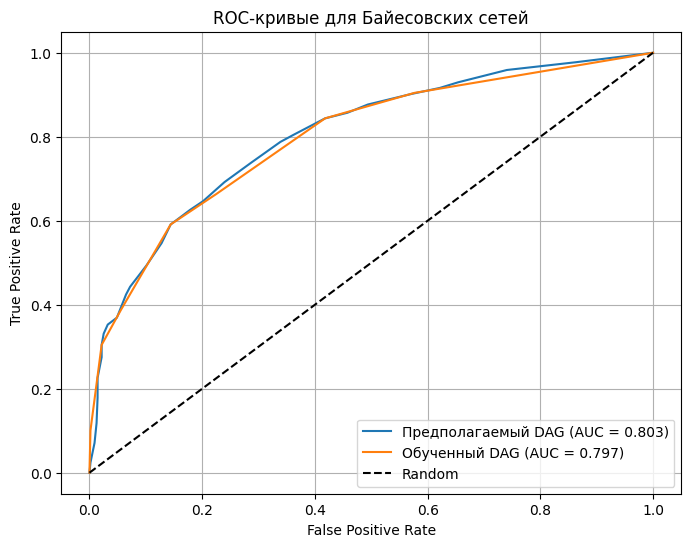

In [44]:
from pgmpy.estimators import HillClimbSearch, BIC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model_defined = DiscreteBayesianNetwork([
    ('sequel', 'rating_r'),
    ('ratings', 'rating_r'),
    ('budget', 'rating_r')
])
model_defined.fit(train_disc, estimator=BayesianEstimator, prior_type='BDeu')
infer_defined = VariableElimination(model_defined)

y_proba_bn_defined = []
for _, row in test_disc.iterrows():
    evidence_dict = {
        'sequel': int(row['sequel']),
        'ratings': int(row['ratings']),
        'budget': int(row['budget'])
    }
    q = infer_defined.query(variables=['rating_r'], evidence=evidence_dict, show_progress=False)
    y_proba_bn_defined.append(q.values[1]) # Вероятность rating_r=1

auc_bn_defined = roc_auc_score(test_disc['rating_r'], y_proba_bn_defined)
print(f"AUC для предполагаемого DAG (ручная структура): {auc_bn_defined:.4f}")

# Обучение структуры DAG из данных
data_for_structure_learning = train_disc[['sequel', 'ratings', 'budget', 'rating_r']]

# HillClimbSearch - один из алгоритмов, BIC - одна из метрик оценки структуры
hc = HillClimbSearch(data=data_for_structure_learning)
best_model_structure = hc.estimate(scoring_method=BIC(data=data_for_structure_learning))
print("\nСтруктура, обученная алгоритмом HillClimbSearch:")
print(best_model_structure.edges())

model_learned_structure = DiscreteBayesianNetwork(best_model_structure.edges())
model_learned_structure.fit(data_for_structure_learning, estimator=BayesianEstimator, prior_type='BDeu')
infer_learned = VariableElimination(model_learned_structure)

y_proba_bn_learned = []
for _, row in test_disc.iterrows():
    evidence_dict_learned = {}
    predictor_nodes = [node for node in model_learned_structure.nodes() if node != 'rating_r' and node in row.index]
    for node in predictor_nodes:
        evidence_dict_learned[node] = int(row[node])
    q_learned = infer_learned.query(variables=['rating_r'], evidence=evidence_dict_learned, show_progress=False)
    y_proba_bn_learned.append(q_learned.values[1])

if len(y_proba_bn_learned) == len(test_disc['rating_r']):
    auc_bn_learned = roc_auc_score(test_disc['rating_r'], y_proba_bn_learned)
    print(f"AUC для DAG с обученной структурой: {auc_bn_learned:.4f}")

    # Сравнение ROC-кривых
    fpr_defined, tpr_defined, _ = roc_curve(test_disc['rating_r'], y_proba_bn_defined)
    fpr_learned, tpr_learned, _ = roc_curve(test_disc['rating_r'], y_proba_bn_learned)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_defined, tpr_defined, label=f'Предполагаемый DAG (AUC = {auc_bn_defined:.3f})')
    plt.plot(fpr_learned, tpr_learned, label=f'Обученный DAG (AUC = {auc_bn_learned:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые для Байесовских сетей')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Длины массивов для AUC не совпадают, пропуск расчета AUC для обученной структуры.")

## 3.8. Выбор лучшего и худшего классификатора

Для выбора лучшей и худшей модели будем использовать AUC на тестовой выборке как основной критерий, так как он комплексно оценивает способность модели разделять классы и устойчив к дисбалансу классов. В качестве дополнительного критерия можно рассмотреть F1-меру на тестовой выборке.


In [45]:
print("--- AUC Scores ---")
print(auc_table)

print("\n--- F1 Scores (после тюнинга по F1) ---")
print(f1_results[['Model', 'Test F1']])

final_comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'KNN', 'Bayesian Network (Defined)', 'Bayesian Network (Learned)'],
    'AUC': [auc_logreg, auc_rf, auc_knn, auc_bn_defined, auc_bn_learned if 'auc_bn_learned' in locals() else 0.0],
    'Test F1': [f1_test_logreg, f1_test_rf, f1_test_knn, 0.0, 0.0]
}
final_df = pd.DataFrame(final_comparison_data)
final_df = final_df.sort_values(by='AUC', ascending=False)

print("\n--- Финальное сравнение моделей ---")
print(final_df)

best_model_name = final_df.iloc[0]['Model']
worst_model_name = final_df.iloc[-1]['Model']

print(f"\nЛучшая модель по AUC: {best_model_name} (AUC={final_df.iloc[0]['AUC']:.4f})")
print(f"Худшая модель по AUC: {worst_model_name} (AUC={final_df.iloc[-1]['AUC']:.4f})")

--- AUC Scores ---
                 Model       AUC
0  Logistic Regression  0.818001
1        Random Forest  0.813350
2                  KNN  0.754390

--- F1 Scores (после тюнинга по F1) ---
                 Model   Test F1
0  Logistic Regression  0.888049
1        Random Forest  0.888153
2                  KNN  0.872993

--- Финальное сравнение моделей ---
                        Model       AUC   Test F1
0         Logistic Regression  0.818001  0.888049
1               Random Forest  0.813350  0.888153
3  Bayesian Network (Defined)  0.802943  0.000000
4  Bayesian Network (Learned)  0.797120  0.000000
2                         KNN  0.754390  0.872993

Лучшая модель по AUC: Logistic Regression (AUC=0.8180)
Худшая модель по AUC: KNN (AUC=0.7544)


## 3.9. Повышенная сложность: дополнительный метод классификации
CatBoost (градиентный бустинг от Яндекса)


In [46]:
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

cat_features_indices = [X_train.columns.get_loc(col) for col in ['director_past_genre', 'sequel'] if col in X_train.columns]

cb_model_base = CatBoostClassifier(verbose=0, random_state=42) # verbose=0 чтобы не было много вывода
cb_model_base.fit(X_train, y_train, cat_features=cat_features_indices if cat_features_indices else None)
y_pred_cb_base_test = cb_model_base.predict(X_test)
y_proba_cb_base_test = cb_model_base.predict_proba(X_test)[:, 1]

auc_cb_base_test = roc_auc_score(y_test, y_proba_cb_base_test)
print(f"CatBoost (базовый) - Test AUC: {auc_cb_base_test:.4f}")

# Сетка гиперпараметров не очень большая для простоты
params_cb = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [1, 3]           # L2 регуляризация
}

cb_classifier = CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_features_indices if cat_features_indices else None)

cb_grid = GridSearchCV(estimator=cb_classifier, param_grid=params_cb, cv=3, scoring='roc_auc', n_jobs=-1)
cb_grid.fit(X_train, y_train)

best_cb_model = cb_grid.best_estimator_
print(f"\nЛучшие параметры для CatBoost: {cb_grid.best_params_}")

y_pred_cb_tuned_test = best_cb_model.predict(X_test)
y_proba_cb_tuned_test = best_cb_model.predict_proba(X_test)[:, 1]

auc_cb_tuned_test = roc_auc_score(y_test, y_proba_cb_tuned_test)
print(f"CatBoost (тюнингованный) - Test AUC: {auc_cb_tuned_test:.4f}")

print(f"\nСравнение CatBoost с лучшей предыдущей моделью ({best_model_name}):")
print(f"AUC лучшей предыдущей модели: {final_df.iloc[0]['AUC']:.4f}")
print(f"AUC тюнингованного CatBoost: {auc_cb_tuned_test:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00
CatBoost (базовый) - Test AUC: 0.8035

Лучшие параметры для CatBoost: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
CatBoost (тюнингованный) - Test AUC: 0.8168

Сравнение CatBoost с лучшей предыдущей моделью (Logistic Regression):
AUC лучшей предыдущей модели: 0.8180
AUC тюнингованного CatBoost: 0.8168


# 4. Регрессия

# 4.1

Отбор признаков для прогнозирования: контрольные переменные (сиквел, бюджет и рейтинг)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, KFold

In [48]:
priznak = ['sequel', 'ratings', 'budget']
prognos = 'revenue'

X = df[priznak]
y = df[prognos]

In [49]:
# Разделение на обучающую и тестовую выборку (25% в тест)
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

x - признаки

y - целевая переменная

In [50]:
X_train = train_df[priznak]
y_train = train_df[prognos]
X_test = test_df[priznak]
y_test = test_df[prognos]

# 4.2

3 модели: для метода МНК, случайного леса и градиентного бустинга

In [51]:
model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train) # обучение моделей
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

Оценка через RMSE и MAPE

In [52]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train) # предсказываем для обуч и тестовой выборки
    y_pred_test = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train)) # берем корень из средней ошибки для RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    train_mape = mean_absolute_percentage_error(y_train, y_pred_train) # среднее значение для MAPE в процентах по определению
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

    print(f"\n{name}")
    print(f"  RMSE train: {train_rmse:.2f}")
    print(f"  RMSE test: {test_rmse:.2f}")
    print(f"  MAPE train: {train_mape:.2%}")
    print(f"  MAPE test: {test_mape:.2%}")

    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mape': train_mape,
        'test_mape': test_mape
    }

In [53]:
results_lr = evaluate_model("Линейная модель МНК", model_lr, X_train, X_test, y_train, y_test)
results_rf = evaluate_model("Случайный лес", model_rf, X_train, X_test, y_train, y_test)
results_gb = evaluate_model("Градиентный бустинг", model_gb, X_train, X_test, y_train, y_test)


Линейная модель МНК
  RMSE train: 22.86
  RMSE test: 22.87
  MAPE train: 6.67%
  MAPE test: 6.70%

Случайный лес
  RMSE train: 22.33
  RMSE test: 22.93
  MAPE train: 6.56%
  MAPE test: 6.69%

Градиентный бустинг
  RMSE train: 22.07
  RMSE test: 22.99
  MAPE train: 6.48%
  MAPE test: 6.71%


Через кросс-валидацию

In [54]:
def cross_validate_model(model, X, y, cv=5): # количество фолдов по умолчанию 5
    kf = KFold(n_splits=cv, shuffle=True, random_state=42) # создаем объект, который делит выборку на 5 частей
    # перемешиваем данные благодаря тру и фиксируем случайность для воспроизводимости
    rmse_scores = []
    mape_scores = [] # создаем пустые списки, где будут результаты значений

    for train_index, val_index in kf.split(X):
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index] # создаем цикл по фолдам, какие сроки для обучения, а какие идут для валидации данных
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index] # валидационная выборка

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred)) # считаем значения из условия, чем меньше, тем лучше
        mape = mean_absolute_percentage_error(y_val, y_pred)

        rmse_scores.append(rmse)
        mape_scores.append(mape) # добавляем результаты в список и берем среднее по всем 5 фолдам

    print(f"  Кросс-валидация RMSE среднее: {np.mean(rmse_scores):.2f}")
    print(f"  Кросс-валидация MAPE среднее: {np.mean(mape_scores):.2%}")
    return rmse_scores, mape_scores

In [55]:
print("\nКросс-валидация на обучающей выборке")
print("Линейная регрессия МНК:")
cross_validate_model(model_lr, X_train, y_train)

print("\nСлучайный лес")
cross_validate_model(model_rf, X_train, y_train)

print("\nГрадиентный бустинг:")
cross_validate_model(model_gb, X_train, y_train)


Кросс-валидация на обучающей выборке
Линейная регрессия МНК:
  Кросс-валидация RMSE среднее: 22.85
  Кросс-валидация MAPE среднее: 6.67%

Случайный лес
  Кросс-валидация RMSE среднее: 22.91
  Кросс-валидация MAPE среднее: 6.69%

Градиентный бустинг:
  Кросс-валидация RMSE среднее: 23.05
  Кросс-валидация MAPE среднее: 6.73%


([np.float64(24.57819985261283),
  np.float64(22.669998249467483),
  np.float64(23.567492257233894),
  np.float64(22.475275576141275),
  np.float64(21.959414198268277)],
 [0.06868940332114255,
  0.06846582189438592,
  0.06649755942038602,
  0.06560848259144346,
  0.06699901921339951])

# 4.3

Линейная регрессия МНК

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer

In [57]:
# Убедимся, что нет NaN или Inf
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
y_train = y_train.loc[X_train.index]

lr = LinearRegression() # нет гиперпараметров у линейной
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [58]:
# Кросс-валидация
rmse_cv_lr = [] # для хранения RMSE по каждому фолду

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx] # индексы обучающего и валид набора
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lr.fit(X_tr, y_tr) # обучаем на обуч части
    preds = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds)) # вычисляем RMSE
    rmse_cv_lr.append(rmse) # сохраняем значения

In [59]:
cv_rmse_lr = np.mean(rmse_cv_lr) # среднее по всем фолдам

lr.fit(X_train, y_train) # переобучение модели на обуч выборке
test_rmse_lr = np.sqrt(mean_squared_error(y_test, lr.predict(X_test))) # на тестовой выборке для сравнения

Подбор гиперпараметров

In [60]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [61]:
# RMSE (нужно отрицательное значение, чем больше лучше)
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Параметры для тюнинга
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 50.0]} # сила регуляризации
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1.0]} # чуть меньшие значения

Ридж регрессия

In [62]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid_ridge = {'ridge__alpha': [0.1, 1.0, 10.0, 50.0]}

In [63]:
# Стандартизация + Ridge
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

In [64]:
# Ridge регрессия с подбором гиперпараметров
grid_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid_ridge,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
# обучает модель на 5 фолдах и вычисляет метрику
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1, param_grid={'ridge__alpha': [0.1, 1.0, 10.0, 50.0]},
             scoring='neg_root_mean_squared_error')

In [65]:
best_ridge = grid_ridge.best_estimator_ # с лучшим значением альфа
cv_rmse_ridge_tuned = -grid_ridge.best_score_ # отрицательное число, поэтому меняем знак
test_rmse_ridge_tuned = np.sqrt(mean_squared_error(y_test, best_ridge.predict(X_test))) # предсказываем на тестовой выборке

Аналогично делаем тюнинг с лассо регрессией

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid_lasso = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0]}

In [67]:
# Стандартизация + Lasso
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

In [68]:
grid_lasso = GridSearchCV(
    lasso_pipeline,
    param_grid_lasso,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
# увеличиваем число итераций
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_

In [69]:
cv_rmse_lasso_tuned = -grid_lasso.best_score_ # извлекаем лучшую модель и выбираем
test_rmse_lasso_tuned = np.sqrt(mean_squared_error(y_test, best_lasso.predict(X_test)))

In [70]:
print(f"Ridge best alpha: {grid_ridge.best_params_['ridge__alpha']}")
print(f"Ridge CV RMSE: {cv_rmse_ridge_tuned:.3f}, Test RMSE: {test_rmse_ridge_tuned:.3f}")

print(f"Lasso best alpha: {grid_lasso.best_params_['lasso__alpha']}")
print(f"Lasso CV RMSE: {cv_rmse_lasso_tuned:.3f}, Test RMSE: {test_rmse_lasso_tuned:.3f}")

Ridge best alpha: 10.0
Ridge CV RMSE: 22.852, Test RMSE: 22.867
Lasso best alpha: 0.01
Lasso CV RMSE: 22.852, Test RMSE: 22.867


In [71]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Initial Params': ['-', 'alpha=[0.1, 1.0, 10.0, 50.0]', 'alpha=[0.001, 0.01, 0.1, 1.0]'],
    'Tuned Param': ['-', grid_ridge.best_params_, grid_lasso.best_params_],
    'CV RMSE': [round(cv_rmse_lr, 2), round(cv_rmse_ridge_tuned, 2), round(cv_rmse_lasso_tuned, 2)],
    'Test RMSE': [round(test_rmse_lr, 2), round(test_rmse_ridge_tuned, 2), round(test_rmse_lasso_tuned, 2)]
})
results

,Model,Initial Params,Tuned Param,CV RMSE,Test RMSE
0,Linear Regression,-,-,22.85,22.87
1,Ridge Regression,"alpha=[0.1, 1.0, 10.0, 50.0]",{'ridge__alpha': 10.0},22.85,22.87
2,Lasso Regression,"alpha=[0.001, 0.01, 0.1, 1.0]",{'lasso__alpha': 0.01},22.85,22.87


Случайный Лес

In [72]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# модель случайного леса со 100 деревьями в ансамбле
rmse_cv_rf_init = [] # кросс-валидация для начальной модели

for train_idx, val_idx in kf.split(X_train):
    rf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    preds = rf.predict(X_train.iloc[val_idx]) # аналогично коду выше, обучаем модель на текущем фолде
    rmse_cv_rf_init.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], preds))) # сохраняем результат RMSE

In [73]:
cv_rmse_rf_init = np.mean(rmse_cv_rf_init) # среднее по всем фолдам
test_rmse_rf_init = np.sqrt(mean_squared_error(y_test, rf.fit(X_train, y_train).predict(X_test))) # оценка на тестовой выборке

подбор гиперпараметров

In [74]:
param_grid_rf = {
    'n_estimators': [100, 200], # сколько деревьев в лесу
    'max_depth': [3, 5, None], # глубина без ограничения
    'min_samples_split': [2, 5], # минимальное число для разбиения узла
    'min_samples_leaf': [1, 2] # минимальное число объектов
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=kf,
                       scoring='neg_root_mean_squared_error', n_jobs=-1) # отриц значение
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_ # ищем наименьший RMSE

In [75]:
cv_rmse_rf_tuned = -grid_rf.best_score_
test_rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))) # после тюнинга

Градиентный бустинг

In [76]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
rmse_cv_gb_init = [] # создание модели ГБ со скоростью обучения 0.1 и пустого списка

In [77]:
for train_idx, val_idx in kf.split(X_train): # запускаем цикл по разбиениям обуч выборки
    gb.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]) # обучение модели на подвыборке и индексиуем строки
    preds = gb.predict(X_train.iloc[val_idx]) # предсказываем для вал части
    rmse_cv_gb_init.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], preds)))

In [78]:
# аналогично считаем среднеквадратичную ошибку между реальными и предсказанными
cv_rmse_gb_init = np.mean(rmse_cv_gb_init)
test_rmse_gb_init = np.sqrt(mean_squared_error(y_test, gb.fit(X_train, y_train).predict(X_test)))

Подбор гиперпараметров

In [79]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=kf,
                       scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_

In [80]:
cv_rmse_gb_tuned = -grid_gb.best_score_
test_rmse_gb_tuned = np.sqrt(mean_squared_error(y_test, best_gb.predict(X_test)))

Результаты в таблице

In [81]:
results = pd.DataFrame({
    'Model': [
        'Linear Regression (OLS)',
        'Ridge Regression',
        'Lasso Regression',
        'Random Forest (Base)',
        'Random Forest (Tuned)',
        'Gradient Boosting (Base)',
        'Gradient Boosting (Tuned)'
    ],
    'Initial Params': [
        '-',
        'alpha=1.0',
        'alpha=1.0',
        'n_estimators=100',
        'various',
        'n_estimators=100, learning_rate=0.1',
        'various'
    ],
    'Tuned Params': [
        '-',
        str(grid_ridge.best_params_),
        str(grid_lasso.best_params_),
        '-',
        str(grid_rf.best_params_),
        '-',
        str(grid_gb.best_params_)
    ],
    'CV RMSE': [
        cv_rmse_lr,
        cv_rmse_ridge_tuned,
        cv_rmse_lasso_tuned,
        cv_rmse_rf_init,
        cv_rmse_rf_tuned,
        cv_rmse_gb_init,
        cv_rmse_gb_tuned
    ],
    'Test RMSE': [
        test_rmse_lr,
        test_rmse_ridge_tuned,
        test_rmse_lasso_tuned,
        test_rmse_rf_init,
        test_rmse_rf_tuned,
        test_rmse_gb_init,
        test_rmse_gb_tuned
    ]
})

results

,Model,Initial Params,Tuned Params,CV RMSE,Test RMSE
0,Linear Regression (OLS),-,-,22.852050,22.866770
1,Ridge Regression,alpha=1.0,{'ridge__alpha': 10.0},22.852023,22.866625
2,Lasso Regression,alpha=1.0,{'lasso__alpha': 0.01},22.852045,22.866500
3,Random Forest (Base),n_estimators=100,-,24.912775,25.250196
4,Random Forest (Tuned),various,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",22.906592,22.929742
5,Gradient Boosting (Base),"n_estimators=100, learning_rate=0.1",-,23.050076,22.985831
6,Gradient Boosting (Tuned),various,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",22.930838,22.910339


Повышенная сложность

In [82]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor

In [83]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Подбор гиперпараметров через OOB ошибку

Случайный лес

Используем RandomForestRegressor, который поддерживает OOB


In [84]:
param_grid_rf = {
    'n_estimators': [100, 200],         # список значений количества деревьев в лесу, которые будем перебирать
    'max_depth': [3, 5, None],          # макс глубина дерева
    'min_samples_split': [2, 5],        # мин число образцов, необходимое для разделения узла; 2 и 5 - варианты
    'min_samples_leaf': [1, 2]          # мин число образцов в листовом узле; 1 или 2 для перебора
}

best_oob_score = np.inf # мин значение
best_params_oob = None # параметр, пока пустой

In [85]:
for n_est in param_grid_rf['n_estimators']: # цикл для каждого значения деревьев
    for depth in param_grid_rf['max_depth']: # для каждого глубины дерева
        for split in param_grid_rf['min_samples_split']: # для каждого мин
            for leaf in param_grid_rf['min_samples_leaf']: # для каждого значения
                rf = RandomForestRegressor(
                    n_estimators=n_est,
                    max_depth=depth,
                    min_samples_split=split,
                    min_samples_leaf=leaf,
                    oob_score=True, # включаем вычисление ошибки
                    random_state=42, # иксируем для воспроизводимости
                    n_jobs=-1 # используем доступные ядра
                )
                rf.fit(X_train, y_train)

                # OOB вычисляем ошибку
                oob_rmse = np.sqrt(mean_squared_error(y_train, rf.oob_prediction_))

                # Сохраняем лучшие параметры по OOB ошибке
                if oob_rmse < best_oob_score:
                    best_oob_score = oob_rmse # если текущая ошибка меньше сохраненного, обновляем лучший результат
                    best_params_oob = {
                        'n_estimators': n_est,
                        'max_depth': depth,
                        'min_samples_split': split,
                        'min_samples_leaf': leaf
                    }

In [86]:
print("Лучшие параметры по OOB:", best_params_oob)
print("OOB RMSE:", best_oob_score)

Лучшие параметры по OOB: {'n_estimators': 200, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}
OOB RMSE: 22.94628382234382


In [87]:
# Обучаем RF с лучшими параметрами и считаем RMSE на тесте
best_rf_oob = RandomForestRegressor(**best_params_oob, oob_score=True, random_state=42)
best_rf_oob.fit(X_train, y_train)
test_rmse_oob = np.sqrt(mean_squared_error(y_test, best_rf_oob.predict(X_test)))
print("Тестовый RMSE с OOB параметрами:", test_rmse_oob)

Тестовый RMSE с OOB параметрами: 22.937355548568867


Подбор гиперпараметров через кросс-валидацию

In [88]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

gb = GradientBoostingRegressor(random_state=42) # градиентный бустинг

grid_gb = GridSearchCV(
    gb,
    param_grid_gb,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [89]:
print("Лучшие параметры по CV:", grid_gb.best_params_)
print("CV RMSE (train):", -grid_gb.best_score_)

# Оцениваем на тестовой выборке
best_gb = grid_gb.best_estimator_
test_rmse_cv = np.sqrt(mean_squared_error(y_test, best_gb.predict(X_test)))
print("Тестовый RMSE с CV параметрами:", test_rmse_cv)

Лучшие параметры по CV: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
CV RMSE (train): 22.931153178322496
Тестовый RMSE с CV параметрами: 22.910686052677956


# 4.5

Повышенная сложность

 Huber loss

In [90]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import time

In [91]:
# Гиперпараметры
LEARNING_RATE = 0.01       # Скорость обучения
EPOCHS = 200               # Количество эпох
DELTA = 1.0                # Гиперпараметр Huber loss
BATCH_SIZE = 128

# Huber loss и его производная
def huber_loss(y_true, y_pred, delta):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2 # записываем функцию вывода значений
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss).mean()

def huber_gradient(X, y_true, y_pred, delta): # производная
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    grad = np.where(is_small_error, -error, -delta * np.sign(error))
    grad_w = X.T @ grad / len(y_true)
    grad_b = grad.mean()
    return grad_w, grad_b

In [92]:
# Обучение модели
def train_huber_regression(X_train, y_train, lr, delta, epochs, batch_size):
    n_samples, n_features = X_train.shape # пишем функцию
    weights = np.zeros(n_features)
    bias = 0.0

    history = [] # создаем пустой список

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        for start in range(0, n_samples, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            y_pred = X_batch @ weights + bias # предсказываем значения по условной функции
            grad_w, grad_b = huber_gradient(X_batch, y_batch, y_pred, delta)

            weights -= lr * grad_w
            bias -= lr * grad_b

        y_epoch_pred = X_train @ weights + bias
        loss = huber_loss(y_train, y_epoch_pred, delta)
        history.append(loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Huber Loss: {loss:.4f}")

    return weights, bias, history

In [93]:
# Преобразуем в numpy
X_train = train_df[priznak].values.astype(float)
y_train = train_df[prognos].values.astype(float)
X_test = test_df[priznak].values.astype(float)
y_test = test_df[prognos].values.astype(float)

# Масштабирование вручную
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

In [94]:
start = time.time() # сколько времени обучается

weights, bias, loss_history = train_huber_regression(
    X_train_scaled, y_train,
    lr=LEARNING_RATE,
    delta=DELTA,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

end = time.time()

Epoch 0, Huber Loss: 243.0937
Epoch 10, Huber Loss: 237.1937
Epoch 20, Huber Loss: 231.2937
Epoch 30, Huber Loss: 225.3937
Epoch 40, Huber Loss: 219.4937
Epoch 50, Huber Loss: 213.5937
Epoch 60, Huber Loss: 207.6937
Epoch 70, Huber Loss: 201.7937
Epoch 80, Huber Loss: 195.8937
Epoch 90, Huber Loss: 189.9937
Epoch 100, Huber Loss: 184.0937
Epoch 110, Huber Loss: 178.1937
Epoch 120, Huber Loss: 172.2937
Epoch 130, Huber Loss: 166.3937
Epoch 140, Huber Loss: 160.4937
Epoch 150, Huber Loss: 154.5937
Epoch 160, Huber Loss: 148.6937
Epoch 170, Huber Loss: 142.7937
Epoch 180, Huber Loss: 136.8937
Epoch 190, Huber Loss: 130.9937


In [95]:
y_pred = X_test_scaled @ weights + bias

# Метрики
mse = np.mean((y_test - y_pred) ** 2)
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

In [96]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

# Метрики
huber = huber_loss(y_test, y_pred, delta=1.0)
test_rmse = rmse(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nМетрики на тестовой выборке:")
print(f"MSE: {mse:.4f}")
print(f"Huber Loss: {huber:.4f}")
print(f"RMSE: {test_rmse:.4f}")


Метрики на тестовой выборке:
MSE: 16680.0892
Huber Loss: 126.2385
RMSE: 129.1514


Градиентный бустинг оказался лучшей моделью из ранее проведенных

# Задание 5. Эффекты воздействия

Объединение обучающей и тестовой выборки

In [97]:
df.info() #исходный датафрейм, который будем использовать

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   revenue              10000 non-null  float64
 1   rating_r             10000 non-null  int64  
 2   sequel               10000 non-null  int64  
 3   ratings              10000 non-null  float64
 4   budget               10000 non-null  float64
 5   director_past_genre  10000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 468.9 KB


# 5.2

Для выделения комплаеров введем гипотетические переменные рейтинга и не от чего независящую величину

In [98]:
# Условная вероятность наличия у фильма рейтинга 18+
# Пороги
u = scipy.stats.uniform.rvs(size = n)

# Симулируем возрастной рейтинг фильма
# с режиссером, который до этого снимал такие фильмы
director_past_genre1 = 1
rating_r_prob1 = logistic.cdf(2.2 * director_past_genre1 + 0.01 * budget  + 0.1 * ratings + 0.001*budget**2 + 0.07*np.log(ratings+1) - 8 + 0.002 *director_past_genre1*ratings)
r1 = (rating_r_prob1 >= u).astype(int) #немного переименуем переменные для удобства

# Симулируем возрастной рейтинг фильма
# с режиссером, который до этого снимал разные фильмы
director_past_genre0 = 0
rating_r_prob0 = logistic.cdf(2.2 * director_past_genre0 + 0.01 * budget  + 0.1 * ratings + 0.001*budget**2 + 0.07*np.log(ratings+1) - 8 + 0.002 *director_past_genre0*ratings)
r0 = (rating_r_prob0 >= u).astype(int) #немного переименуем переменные для удобства

# Соблюдатели
compliers = r1 > r0

# Факт наличия у фильма рейтинга 18+
rating_r               = np.zeros(n)
rating_r[director_past_genre == 1] = r1[director_past_genre == 1]
rating_r[director_past_genre == 0] = r0[director_past_genre == 0]

# Доли фильмов с рейтингом 18+ и соблюдателей
print(pd.DataFrame(data    = [np.mean(compliers), np.mean(rating_r)],
                   index   = ['P(compliers = 1)', 'P(rating_r = 1)'],
                   columns = ['Оценка']))


                  Оценка
P(compliers = 1)  0.2139
P(rating_r = 1)   0.7858


In [99]:
#Кассовые сборы для разных ситуаций
revenue_0 = g0 + error0
revenue_1 = g1 + error1

#Наблюдаемые кассовые сборы
revenue = np.zeros(n)
revenue[rating_r == 0] = revenue_0[rating_r == 0]
revenue[rating_r == 1] = revenue_1[rating_r == 1]


In [100]:
data = pd.DataFrame({'rating_r': rating_r,  'budget': budget,
                   'ratings': ratings,   'sequel': sequel,
                   'director_past_genre': director_past_genre, 'revenue': revenue})
# Посмотрим на симулированные данные
data.head(10).style.format(precision = 2)

,rating_r,budget,ratings,sequel,director_past_genre,revenue
0,1.00,86.09,7.46,0,0,75.98
1,1.00,88.50,6.96,0,0,82.16
2,1.00,84.82,6.05,0,1,96.10
3,1.00,90.77,7.61,0,1,115.60
4,0.00,94.03,6.78,1,0,126.15
5,1.00,106.10,6.61,0,0,107.45
6,1.00,79.63,6.40,1,1,91.71
7,1.00,86.12,6.81,0,0,74.08
8,1.00,100.03,7.23,0,0,103.32
9,1.00,97.12,4.37,0,1,99.45


In [101]:
# Настоящие эффекты воздействия (не наблюдаются в данных)
TE = revenue_1 - revenue_0
print(TE[0:10])

[-43.62316277 -30.5055982  -19.45948701   9.34577713   8.04128734
 -38.91570425 -22.65526633 -33.81899411 -20.83929457 -19.94933414]


Оценим средний эффект воздействия

In [102]:
# Точное приближение среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
ATE = np.mean(TE)

# Точное приближение локального среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
LATE = np.mean(TE[compliers])

results_table = pd.DataFrame({
    "Метрика": ["ATE (Средний эффект)", "LATE (Локальный средний эффект)"],
    "Значение": [ATE, LATE]})

results_table

,Метрика,Значение
0,ATE (Средний эффект),-12.834587
1,LATE (Локальный средний эффект),-10.654991


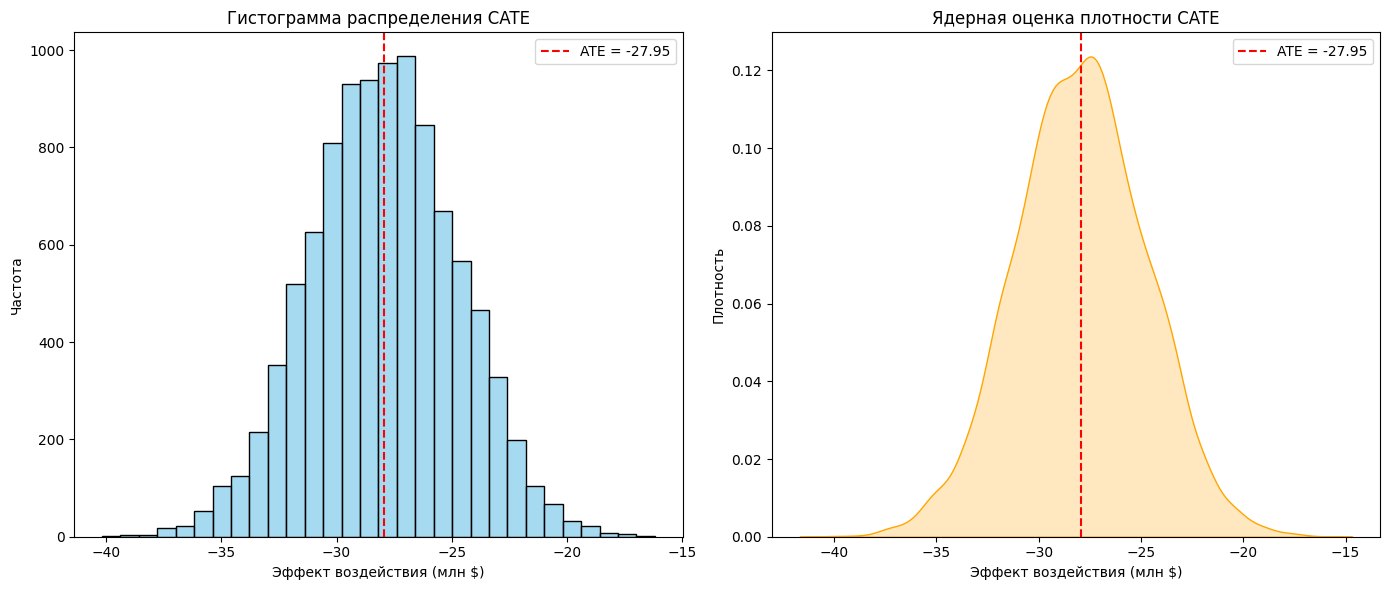

In [103]:
from scipy.stats import gaussian_kde

# Рассчитываем индивидуальные эффекты воздействия
CATE = g1 - g0

# Создаем фигуру с двумя графиками
plt.figure(figsize=(14, 6))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(CATE, bins=30, kde=False, color='skyblue')
plt.axvline(x=np.mean(CATE), color='red', linestyle='--', label=f'ATE = {np.mean(CATE):.2f}')
plt.title('Гистограмма распределения CATE')
plt.xlabel('Эффект воздействия (млн $)')
plt.ylabel('Частота')
plt.legend()

# Ядерная оценка плотности
plt.subplot(1, 2, 2)
sns.kdeplot(CATE, fill=True, color='orange')
plt.axvline(x=np.mean(CATE), color='red', linestyle='--', label=f'ATE = {np.mean(CATE):.2f}')
plt.title('Ядерная оценка плотности CATE')
plt.xlabel('Эффект воздействия (млн $)')
plt.ylabel('Плотность')
plt.legend()

plt.tight_layout()
plt.show()



# 5.3

Оценивание ATE как разницы в средних

In [104]:
# Наивная оценка как разница в выборочных средних
ATE_naive = np.mean(revenue[rating_r == 1]) - np.mean(revenue[rating_r == 0])

# Сравнение точного приближения и наивной оценки
print(pd.DataFrame(data    = [ATE, ATE_naive],
                   index   = ['ATE', 'ATE naive'],
                   columns = ['Оценка']))

              Оценка
ATE       -12.834587
ATE naive   1.259453


# 5.4

Оценка с помощью метода наименьших квадратов

In [105]:
# МНК оценивание для фильмов без сцен 18+
y0  = df.loc[rating_r == 0, ['revenue']]
x0  = df.loc[rating_r == 0, df.columns.drop(['revenue',	'rating_r','director_past_genre'])]
x0  = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

# МНК оценивание для фильмов со сценами 18+
y1  = df.loc[rating_r == 1, ['revenue']]
x1  = df.loc[rating_r == 1, df.columns.drop(['revenue',	'rating_r','director_past_genre'])]
x1  = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

#Оценим кассовые сборы при наличии или отсутствии рейтинга R

x = df.loc[:, df.columns.drop(['revenue',	'rating_r','director_past_genre'])]
x = sm.add_constant(x)
  # МНК оценка E(revenue0 | X) для всех фильмов
wage0_ls = ls0.predict(x)
  # МНК оценка E(revenue1 | X) для всех фильмов
wage1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(wage1_ls - wage0_ls)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)

In [106]:
# Сравним результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls],
                   index   = ['ATE', 'ATE naive', "ATE ls"],
                   columns = ['Оценка']))

              Оценка
ATE       -12.834587
ATE naive   1.259453
ATE ls     -1.052533


Оценивание с помощью условных математических ожиданий

In [107]:
# Подготовка данных
X = df.drop(columns=['revenue', 'rating_r', 'director_past_genre'])
y = df['revenue']
T = df['rating_r']

# 1. Настройка модели градиентного бустинга
gb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_samples_split': 10,
    'random_state': 42
}

# Модель для фильмов со сценами 18+
gb1 = GradientBoostingRegressor(**gb_params).fit(X[T == 1], y[T == 1])

# Модель для фильмов без сцен 18+
gb0 = GradientBoostingRegressor(**gb_params).fit(X[T == 0], y[T == 0])

# Прогнозирование потенциальных исходов
y1_pred = gb1.predict(X)  # E[Y|X,T=1]
y0_pred = gb0.predict(X)  # E[Y|X,T=0]

# Оценка ATE
ATE_gb = np.mean(y1_pred - y0_pred)
print(f"ATE (градиентный бустинг): {ATE_gb:.2f}")


ATE (градиентный бустинг): -13.30


Оценка с помощью взвешивания на обратные вероятности

In [108]:
# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target   = df.loc[:, ['rating_r']]
features = df.loc[:, df.columns.drop(['revenue', 'rating_r', 'director_past_genre'])]

# Подготовим метод машинного обучения
gb = GradientBoostingClassifier(loss          = 'log_loss',
                                n_estimators  = 100,
                                learning_rate = 0.1)
gb.fit(features, target)

# Оценим условные вероятности P(educ = 1 | X)
prob_gb = gb.predict_proba(features)[:, 1]

# Оценим псевдоисходы
wage_pseudo = (revenue * rating_r) / prob_gb - (revenue * (1 - rating_r)) / (1 - prob_gb)

# Оценим ATE
ATE_IPW = np.mean(wage_pseudo)
print(ATE_IPW)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-12.248002597296551


Оценим с помощью метода двойной устойчивости

In [109]:
# Подготовим данные
y = df.loc[:, ['revenue']]
x = df.loc[:, df.columns.drop(['revenue', 'director_past_genre'])]

# Подготовка модели
rf2 = GradientBoostingRegressor(n_estimators = 100,
                            max_depth    = 20,
                            max_features = 3)
rf2.fit(x, y)

x0         = deepcopy(x)
x0["rating_r"] = 0
revenue0_rf2  = rf2.predict(x0)

x1         = deepcopy(x)
x1["rating_r"] = 1
revenue1_rf2  = rf2.predict(x1)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [110]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((revenue1_rf2 - revenue0_rf2) + \
                 rating_r * (revenue - revenue1_rf2) / prob_gb - \
                 (1 - rating_r) * (revenue - revenue0_rf2) / (1 - prob_gb))
print(ATE_DR)

-11.133666326539382


Оценим с помощью двойного машинного обучения


In [111]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data   = df,
                            y_col  = 'revenue',
                            d_cols = 'rating_r',
                            x_cols = ['budget', 'ratings', 'sequel'])

# Метод оценивания E(Y | X, T)
g_Y = GradientBoostingRegressor(n_estimators = 100,
                            max_depth    = 20,
                            max_features = 3)

# Метод оценивания E(T | X)
g_T = LogisticRegression(max_iter=1000, random_state=42)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g         = g_Y,
                               ml_m         = g_T,
                               n_rep        = 1,
                               n_folds      = 5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard = dml_standard.coef[0]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [112]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_gb, ATE_IPW, ATE_DR, ATE_dml_standard],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE_gb','ATE_IPW', 'ATE_DR', 'ATE dml standard'],
                   columns = ['Оценка']))

                     Оценка
ATE              -12.834587
ATE naive          1.259453
ATE ls            -1.052533
ATE_gb           -13.297501
ATE_IPW          -12.248003
ATE_DR           -11.133666
ATE dml standard -13.187451


Задание повышенной сложности: метод синтетического контроля

In [113]:
from sklearn.linear_model import LassoCV

def synthetic_control(X, T, y):
    treated = y[T==1].mean()
    control = X[T==0]


    model = LassoCV(cv=min(3, len(control)-1))
    model.fit(control.T, X[T==1].mean().values)
    weights = model.coef_
    weights = np.clip(weights, 0, None)  # Только положительные веса
    weights /= weights.sum()

    synthetic = (y[T==0] @ weights)
    return treated - synthetic

X = df.drop(columns=['revenue', 'rating_r', 'director_past_genre'])
y = df['revenue']
T = df['rating_r']
ate_sc = synthetic_control(X, T, y)
print(f"Synthetic Control ATE: {ate_sc:.2f}")

Synthetic Control ATE: -12.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.120e+00, tolerance: 5.041e-01
  model = cd_fast.enet_coordinate_descent(


In [114]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_gb, ATE_IPW, ATE_DR, ATE_dml_standard, ate_sc],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE_gb','ATE_IPW', 'ATE_DR', 'ATE dml standard', 'ATE_SC'],
                   columns = ['Оценка']))

                     Оценка
ATE              -12.834587
ATE naive          1.259453
ATE ls            -1.052533
ATE_gb           -13.297501
ATE_IPW          -12.248003
ATE_DR           -11.133666
ATE dml standard -13.187451
ATE_SC           -12.000887


# 5.5

Двойное машинное обучение без инструментальной переменной

In [115]:
# Данные в формате, необходимом для применения DML
dml_standard2_data = dml.DoubleMLData(
                             data   = df,
                             y_col  = 'revenue',
                             d_cols = 'rating_r',
                             x_cols = ['ratings', 'sequel'])

# Подготовка объекта
dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g         = g_Y,
                                ml_m         = g_T,
                                n_rep        = 1,
                                n_folds      = 5)

# Оценим параметры
dml_standard2.fit()

# Посмотрим на результат
print(dml_standard2)

# Сохраним оценку
LATE_dml_standard2 = dml_standard2.coef[0]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: revenue
Treatment variable(s): ['rating_r']
Covariates: ['ratings', 'sequel']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(max_depth=20, max_features=3)
Learner ml_m: LogisticRegression(max_iter=1000, random_state=42)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[18.15390314]]
Learner ml_g1 RMSE: [[32.64516116]]
Classification:
Learner ml_m Log Loss: [[0.51865467]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
            coef   std err         t     P>|t|     2.5 %    97.5 %
rating_r  1.1126  0.490968  2.266136  0.023443  0.150321  2.074879


Двойное машинное обучение с инструментальной переменной

In [116]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data   = df,
                               y_col  = 'revenue',
                               d_cols = 'rating_r',
                               z_cols = 'director_past_genre',
                               x_cols = ['ratings', 'sequel'])

# Метод оценивания E(Z | X)
g_Z = GradientBoostingClassifier(loss          = 'log_loss',
                                 n_estimators  = 100,
                                 learning_rate = 0.1)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g         = g_Y,
                          ml_m         = g_Z,
                          ml_r         = g_T,
                          n_rep        = 1,
                          n_folds      = 5)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv = dml_iv.coef[0]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: revenue
Treatment variable(s): ['rating_r']
Covariates: ['ratings', 'sequel']
Instrument variable(s): ['director_past_genre']
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(max_depth=20, max_features=3)
Learner ml_m: GradientBoostingClassifier()
Learner ml_r: LogisticRegression(max_iter=1000, random_state=42)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[29.61677378]]
Learner ml_g1 RMSE: [[35.28382676]]
Classification:
Learner ml_m Log Loss: [[0.62526249]]
Learner ml_r0 Log Loss: [[0.59701988]]
Learner ml_r1 Log Loss: [[0.25902321]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
    

In [117]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, LATE, LATE_dml_standard2, LATE_dml_iv],
                   index   = ['ATE', 'LATE', 'LATE dml standard2', 'LATE dml iv',],
                   columns = ['Оценка']))

                       Оценка
ATE                -12.834587
LATE               -10.654991
LATE dml standard2   1.112600
LATE dml iv        -14.117499


Повышенная сложность:

In [118]:
from statsmodels.discrete.discrete_model import Probit

X = df[['director_past_genre', 'budget', 'sequel', 'ratings']]
y = df['revenue']
T = df['rating_r']

# 1. Probit модель для отбора
probit = Probit(T, sm.add_constant(X)).fit(disp=0)
prob_treated = probit.predict(sm.add_constant(X))

# 2. 2SLS с поправкой Хекмана
# Inverse Mills ratio
lambda_ = probit.predict(sm.add_constant(X), linear=True) / probit.predict(sm.add_constant(X))

# Вторая стадия
X_2sls = sm.add_constant(pd.DataFrame({
    'rating_r': T,
    'budget': X['budget'],
    'sequel': X['sequel'],
    'ratings': X['ratings'],
    'lambda': lambda_
}))

model_2sls = sm.OLS(y, X_2sls).fit()

late_par = round(model_2sls.params['rating_r'], 2)

# LATE (коэфф. rating_r)
print(f"LATE estimate: {late_par}")

LATE estimate: -10.73


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


In [119]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, LATE, LATE_dml_standard2, LATE_dml_iv, late_par],
                   index   = ['ATE', 'LATE', 'LATE dml standard2', 'LATE dml iv', 'LATE par. model'],
                   columns = ['Оценка']))

                       Оценка
ATE                -12.834587
LATE               -10.654991
LATE dml standard2   1.112600
LATE dml iv        -14.117499
LATE par. model    -10.730000


# 5.6

Воспользуемся методом наименьших квадратов

In [129]:
# Оценки CATE (код взят из пункта 5.4)
CATE_ls = np.array(wage1_ls - wage0_ls)
print(CATE_ls)

E_ls = np.mean(np.concatenate([wage0_ls, wage1_ls])) #для последующих пунктов


[-1.34416034 -1.57785758 -1.94557133 ...  0.19257005 -1.97855626
 -2.57756839]


Воспользуемся методом S-learner

In [130]:
# CATE с помощью S-learner

# Подготовим данные
y = df.loc[:, ['revenue']]
x = df.loc[:, df.columns.drop(['revenue', 'director_past_genre'])]

# Подготовка модели
rf2 = GradientBoostingRegressor(n_estimators = 100,
                            max_depth    = 20,
                            max_features = 3)
rf2.fit(x, y)

x0         = deepcopy(x)
x0["rating_r"] = 0
revenue0_rf2  = rf2.predict(x0)

x1         = deepcopy(x)
x1["rating_r"] = 1
revenue1_rf2  = rf2.predict(x1)

# Оценки CATE
CATE_S = revenue1_rf2 - revenue0_rf2

E_S = np.mean(np.concatenate([revenue0_rf2, revenue1_rf2]))

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Воспользуемся методом T-learner

In [132]:
# Подготовка данных
features = df.columns.drop(['revenue', 'director_past_genre', 'rating_r'])
X = df[features]
y = df['revenue']
T = df['rating_r']

# Добавляем константу для OLS
X_const = sm.add_constant(X)

# 1. МНК оценивание для фильмов без рейтинга R (T=0)
y0 = y[T == 0]
X0 = X_const[T == 0]
ls0 = sm.OLS(y0, X0).fit()

# 2. МНК оценивание для фильмов с рейтингом R (T=1)
y1 = y[T == 1]
X1 = X_const[T == 1]
ls1 = sm.OLS(y1, X1).fit()

# 3. Gradient Boosting модели
rf = GradientBoostingRegressor(n_estimators=100, max_depth=20, max_features=3)

# Обучение на группе T=0
rf0 = clone(rf).fit(X[T == 0], y[T == 0].values.ravel())  # Используем .ravel() для 1D массива

# Обучение на группе T=1
rf1 = clone(rf).fit(X[T == 1], y[T == 1].values.ravel())

# Предсказания для всех наблюдений
revenue0_pred = rf0.predict(X)
revenue1_pred = rf1.predict(X)

# Оценка CATE
CATE_T = revenue1_pred - revenue0_pred

E_T = np.mean(np.concatenate([revenue0_pred, revenue1_pred]))

Воспользуемся методом трансформации классов

In [137]:
# Оценим CATE методом трансформации классов

features = df.loc[:, df.columns.drop(['revenue', 'rating_r', 'director_past_genre'])]
target   = df.loc[:, ['rating_r']]


# Подготовим метод машинного обучения
gb = GradientBoostingClassifier(loss          = 'log_loss',
                                n_estimators  = 100,
                                learning_rate = 0.1)
gb.fit(features, target)

# Оценим условные вероятности
prob_gb = gb.predict_proba(features)[:, 1]

# Оценим псевдоисходы
wage_pseudo = (revenue * rating_r) / prob_gb - (revenue * (1 - rating_r)) / (1 - prob_gb)


rf3 = GradientBoostingRegressor(n_estimators = 100,
                            max_depth    = 5,
                            max_features = 3)
# Обучение модели
rf3.fit(features, wage_pseudo)

# Оценки CATE (метод трансформации классов)
CATE_CT = rf3.predict(features)

E_CT = np.mean(rf3.predict(features))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Воспользуемся методом X-learner

In [143]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

def x_learner_cate(X, T, y):
    # Шаг 1: Обучаем базовые модели (T-learner)
    model1 = GradientBoostingRegressor(n_estimators=100, max_depth=5).fit(
        X[T == 1], y[T == 1])
    model0 = GradientBoostingRegressor(n_estimators=100, max_depth=5).fit(
        X[T == 0], y[T == 0])

    # Прогнозы для всей выборки (для расчета общего среднего)
    pred1_all = model1.predict(X)  # Прогнозы как если бы все были T=1
    pred0_all = model0.predict(X)  # Прогнозы как если бы все были T=0
    prop_treated = np.mean(T)      # Доля наблюдений с T=1

    # Шаг 2: Вычисляем псевдо-эффекты
    # Для группы T=1: y_i - μ0(x_i)
    treated_idx = np.where(T == 1)[0]
    pseudo_effect_treated = y[T == 1] - model0.predict(X[T == 1])

    # Для группы T=0: μ1(x_i) - y_i
    control_idx = np.where(T == 0)[0]
    pseudo_effect_control = model1.predict(X[T == 0]) - y[T == 0]

    # Шаг 3: Обучаем модели на псевдо-эффектах
    tau1_model = GradientBoostingRegressor(n_estimators=100, max_depth=5).fit(
        X.iloc[treated_idx], pseudo_effect_treated)
    tau0_model = GradientBoostingRegressor(n_estimators=100, max_depth=5).fit(
        X.iloc[control_idx], pseudo_effect_control)

    # Шаг 4: Оцениваем propensity score
    ps_model = CalibratedClassifierCV(
        LogisticRegression(), cv=3).fit(X, T)
    ps = ps_model.predict_proba(X)[:, 1]
    ps = np.clip(ps, 0.1, 0.9)  # Избегаем крайних значений

    # Шаг 5: Комбинируем предсказания с весами
    tau1_pred = tau1_model.predict(X)
    tau0_pred = tau0_model.predict(X)

    # Взвешенное среднее
    cate = ps * tau0_pred + (1 - ps) * tau1_pred
    overall_pred = prop_treated * np.mean(pred1_all) + (1 - prop_treated) * np.mean(pred0_all)

    return cate, overall_pred


# Вычисляем CATE
cate_x, E_x = x_learner_cate(X, T, y)

Повышенная сложность: Casual Forest

In [147]:
from sklearn.base import BaseEstimator

class CausalForest(BaseEstimator):
    def __init__(self, n_estimators=100, min_samples_leaf=10):
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, T, y):
        self.models = []
        for _ in range(self.n_estimators):
            # Бутстрап выборка
            idx = np.random.choice(len(X), size=len(X), replace=True)
            X_boot, T_boot, y_boot = X.iloc[idx], T.iloc[idx], y.iloc[idx]

            # Обучаем модель для treated и control
            rf1 = RandomForestRegressor(min_samples_leaf=self.min_samples_leaf)
            rf0 = RandomForestRegressor(min_samples_leaf=self.min_samples_leaf)

            rf1.fit(X_boot[T_boot==1], y_boot[T_boot==1])
            rf0.fit(X_boot[T_boot==0], y_boot[T_boot==0])

            self.models.append((rf1, rf0))
        return self

    def effect(self, X):
        effects = []
        for rf1, rf0 in self.models:
            effects.append(rf1.predict(X) - rf0.predict(X))
        return np.mean(effects, axis=0)

# Использование
causal_forest = CausalForest(n_estimators=100)
causal_forest.fit(X, T, y)
cate_cf = causal_forest.effect(X)

In [140]:
# Объединим полученные ранее оценки CATE
CATE_mat = pd.DataFrame({'True': CATE, 'LS': CATE_ls, 'S-learner': CATE_S,
                         'T-learner': CATE_T, 'Class Transformation': CATE_CT,'X-learner': cate_x, 'Casual Forest': cate_cf})
print(CATE_mat)

           True        LS  S-learner  T-learner  Class Transformation  \
0    -27.840685 -1.344160 -25.501814 -29.457406             42.975266   
1    -28.410978 -1.577858 -27.678481 -23.863340            -52.707185   
2    -28.408803 -1.945571 -10.303339 -10.957373             14.129185   
3    -30.709268 -1.314878   9.843135  10.938749             70.503944   
4    -28.015323  0.670168   5.519333   8.737515          -1846.585785   
...         ...       ...        ...        ...                   ...   
9995 -30.827041 -2.643136   6.299623   9.965148            199.949905   
9996 -31.134709 -1.597144 -25.590595 -32.945181            253.720216   
9997 -24.897627  0.192570  17.212182  22.179273            -27.905879   
9998 -24.303715 -1.978556  27.404384   6.339206             27.911293   
9999 -31.829029 -2.577568 -30.610470 -44.496665            143.938739   

      X-learner  Casual Forest  
0    -13.873278     -17.114912  
1    -13.690586     -22.637145  
2    -10.834289     -11.

# 5.7

In [144]:
# Сравнение оценок CATE на основании истинных значений (по среднеквадратичной ошибке)
CATE_MSE0 = pd.DataFrame(data    = [np.mean((CATE_ls  - CATE) ** 2),
                                    np.mean((CATE_T   - CATE) ** 2),
                                    np.mean((CATE_S   - CATE) ** 2),
                                    np.mean((CATE_CT  - CATE) ** 2),
                                    np.mean((cate_x   - CATE) ** 2),
                                    np.mean((cate_cf   - CATE) ** 2)],
                         index   = ['LS', 'T-learner', 'S-learner', 'CT', 'X', 'Casual Forest'],
                         columns = ['MSE0'])
print(CATE_MSE0)

                        MSE0
LS                733.245354
T-learner         786.067003
S-learner         628.252856
CT             365411.152010
X                 237.983419
Casual Forest     289.254392


In [149]:
# Сравнение CATE на основании прогнозной точности моделей

CATE_MSE1 = pd.DataFrame(data    = [np.mean((revenue - E_ls) ** 2),
                                    np.mean((revenue - E_T) ** 2),
                                    np.mean((revenue - E_S) ** 2),
                                    np.mean((revenue - E_CT) ** 2),
                                    np.mean((revenue - E_x) ** 2)],
                         index   = ['LS', 'T-learner', 'S-learner', 'CT', 'X'],
                         columns = ['MSE1'])
print(CATE_MSE1)


                   MSE1
LS           621.414473
T-learner    640.481162
S-learner    636.125536
CT         60954.861625
X            621.774841


In [150]:
# Сравнение CATE на основании псевдоисходов
CATE_MSE2 = pd.DataFrame(data    = [np.mean((wage_pseudo - CATE_ls) ** 2),
                                    np.mean((wage_pseudo - CATE_T) ** 2),
                                    np.mean((wage_pseudo - CATE_S) ** 2),
                                    np.mean((wage_pseudo - CATE_CT) ** 2),
                                    np.mean((wage_pseudo - cate_x) ** 2),
                                    np.mean((wage_pseudo - cate_cf) ** 2)],
                         index   = ['LS', 'T-learner', 'S-learner', 'CT', 'X', 'Casual Forest'],
                         columns = ['MSE2'])
print(CATE_MSE2)

                       MSE2
LS             1.424700e+06
T-learner      1.425214e+06
S-learner      1.424779e+06
CT             5.749983e+05
X              1.424941e+06
Casual Forest  1.424878e+06


# 5.8

Оценка с помощью метода двойного машинного обучения

In [155]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
    data=df,
    y_col='revenue',
    d_cols='rating_r',
    x_cols=['budget', 'ratings', 'sequel'])

# Метод оценивания E(Y | X, T)
g_Y = RandomForestRegressor(n_estimators=100,
                          max_depth=20,
                          max_features=3,
                          random_state=42)

# Метод оценивания E(T | X) - исправленная версия
g_T = KNeighborsClassifier(n_neighbors=5)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(
    obj_dml_data=dml_standard_data,
    ml_g=g_Y,
    ml_m=g_T,
    n_rep=1,
    n_folds=5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_worst = dml_standard.coef[0]
print(f"ATE (DoubleML): {ATE_dml_worst:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ATE (DoubleML): -16.5588


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:194: UserWarning: Propensity predictions from learner KNeighborsClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/doubleml/double_ml.py:1470: UserWarning: The estimated nu2 for rating_r is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)


In [161]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data=df,
                              y_col='revenue',
                              d_cols='rating_r',
                              z_cols='director_past_genre',
                              x_cols=['ratings', 'sequel'])

# Метод оценивания E(Z | X)
g_Z = RandomForestClassifier(n_estimators=100,
                           max_depth=5,
                           random_state=42)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data=dml_iv_data,
                         ml_g=g_Y,
                         ml_m=g_Z,
                         ml_r=g_T,
                         n_rep=1,
                         n_folds=5)

# Оценим параметры
dml_iv.fit()

# Сохраним оценку
LATE_dml_iv_worst = dml_iv.coef[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [163]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_gb, ATE_IPW, ATE_DR, ATE_dml_standard, ate_sc, ATE_dml_worst, LATE, LATE_dml_iv, late_par, LATE_dml_iv_worst],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE_gb','ATE_IPW', 'ATE_DR', 'ATE dml standard', 'ATE_SC','ATE dml worst','LATE', 'LATE dml iv', 'LATE par. model', 'LATE_dml_iv_worst'],
                   columns = ['Оценка']))


                      Оценка
ATE               -12.834587
ATE naive           1.259453
ATE ls             -1.052533
ATE_gb            -13.297501
ATE_IPW           -12.248003
ATE_DR            -11.133666
ATE dml standard  -17.766180
ATE_SC            -12.000887
ATE dml worst     -16.558831
LATE              -10.654991
LATE dml iv       -14.660768
LATE par. model   -10.730000
LATE_dml_iv_worst -13.505978
